In [1]:
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

%cd "C:\Users\artemiyburov\prog\epidemic-datathon\"

C:\Users\artemiyburov\prog\epidemic-datathon


In [2]:
df = pd.read_csv("worldwide-aggregated.csv")
#df.plot(y='Confirmed', use_index = True)

x = df.index       #features
y = df['Confirmed']#labels
x_predicted = np.arange(356)

In [3]:
def logistic_function(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

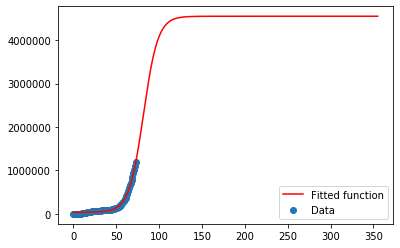

In [4]:
popt, pcov = curve_fit(logistic_function, x, y)
plt.scatter(x,y,label='Data')
plt.plot(x_predicted, logistic_function(x_predicted, *popt), 'r-',label='Fitted function')
plt.legend()